In [42]:
import os
import re
import subprocess
from collections import defaultdict
import numpy as np
import rasterio
from rasterio.merge import merge
from rasterio.warp import reproject, Resampling
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import glob
import json
from tqdm import tqdm
import yaml

#import geopandas as gpd
import pandas as pd

import torch

import sys
sys.path.append('../')

import utils.basics as bsc 
import utils.plotting as pt
import utils.processing as proc
import utils.eval_pipe as eval

import utils.model_loader as md
import utils.data_loader as dt
import utils.config_loader as cf

%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## For Loop first 6 experiments

In [4]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:6]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

experiment_names


['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem']

=== NEW EXPERIMENT ===
 --> Name: baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 250/250 [03:32<00:00,  1.18it/s]

Results saved to: ../results/train/baseline


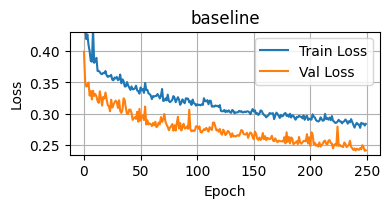

Minimum Validation Loss:  0.24103969064625827
DONE WITH  baseline
=== NEW EXPERIMENT ===
 --> Name: pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs: 100%|██████████| 250/250 [04:03<00:00,  1.03it/s]


Results saved to: ../results/train/pixel_composites


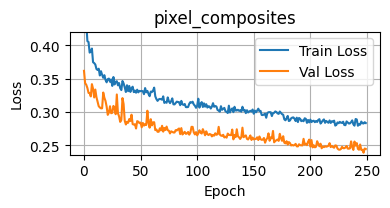

Minimum Validation Loss:  0.23897571726278824
DONE WITH  pixel_composites
=== NEW EXPERIMENT ===
 --> Name: seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 250/250 [03:33<00:00,  1.17it/s]


Results saved to: ../results/train/seasonal_composites


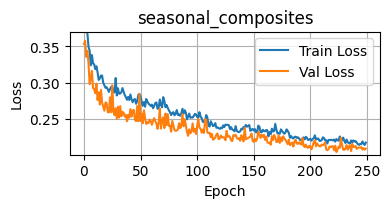

Minimum Validation Loss:  0.203791394447669
DONE WITH  seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: pixel_and_seasonal
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [06:42<00:00,  1.61s/it]


Results saved to: ../results/train/pixel_and_seasonal


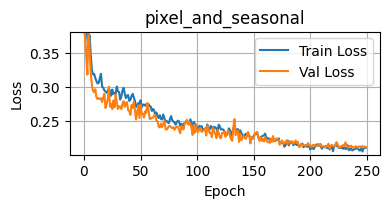

Minimum Validation Loss:  0.2098698188097049
DONE WITH  pixel_and_seasonal
=== NEW EXPERIMENT ===
 --> Name: all_aux_data
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 250/250 [06:58<00:00,  1.67s/it]


Results saved to: ../results/train/all_aux_data


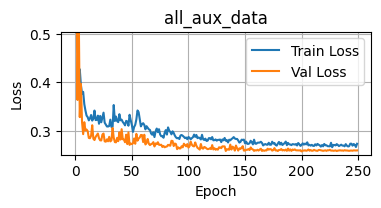

Minimum Validation Loss:  0.2568476605109679
DONE WITH  all_aux_data
=== NEW EXPERIMENT ===
 --> Name: mid_level_learning
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 250/250 [09:20<00:00,  2.24s/it]


Results saved to: ../results/train/mid_level_learning


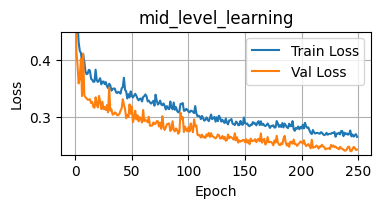

Minimum Validation Loss:  0.23955446193560712
DONE WITH  mid_level_learning


In [72]:
for exp_name in experiment_names:

    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")



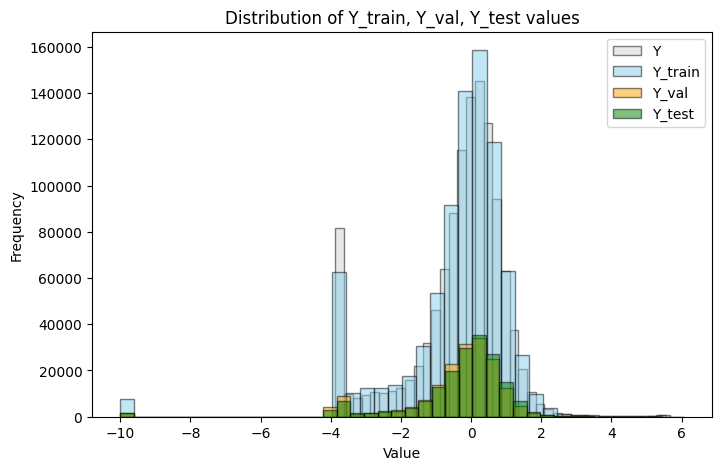

In [44]:
plt.figure(figsize=(8, 5))

plt.hist(Y.flatten(), bins=40, alpha=0.5, label='Y', color='lightgray', edgecolor='black')
plt.hist(Y_train.flatten(), bins=40, alpha=0.5, label='Y_train', color='skyblue', edgecolor='black')
plt.hist(Y_val.flatten(), bins=40, alpha=0.5, label='Y_val', color='orange', edgecolor='black')
plt.hist(Y_test.flatten(), bins=40, alpha=0.5, label='Y_test', color='green', edgecolor='black')

plt.title("Distribution of Y_train, Y_val, Y_test values")
plt.xlabel("Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

In [91]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [92]:
experiment_names

['01_baseline',
 '02_pixel_composites',
 '03_seasonal_composites',
 '04_pixel_and_seasonal_comp',
 '05_support_fmask_dlt',
 '06_support_fmask_dlt_dem',
 '07_aux_task']

=== NEW EXPERIMENT ===
 --> Name: 01_baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 300/300 [04:20<00:00,  1.15it/s]

Results saved to: ../results/train/01_baseline


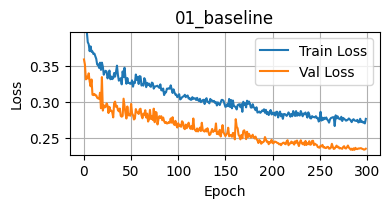

Minimum Validation Loss:  0.23335113308646463
DONE WITH  01_baseline
=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs: 100%|██████████| 300/300 [08:46<00:00,  1.76s/it]


Results saved to: ../results/train/02_pixel_composites


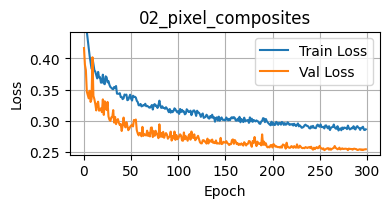

Minimum Validation Loss:  0.2527458830313249
DONE WITH  02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 300/300 [04:19<00:00,  1.15it/s]


Results saved to: ../results/train/03_seasonal_composites


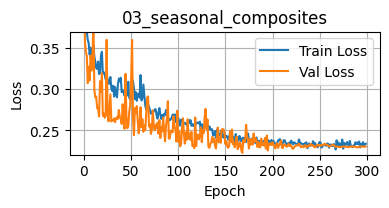

Minimum Validation Loss:  0.22244974092031136
DONE WITH  03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 04_pixel_and_seasonal_comp
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 300/300 [08:20<00:00,  1.67s/it]


Results saved to: ../results/train/04_pixel_and_seasonal_comp


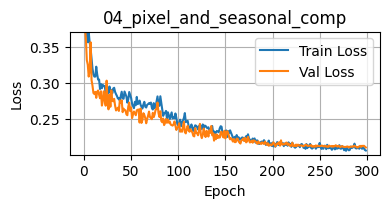

Minimum Validation Loss:  0.21060184484873062
DONE WITH  04_pixel_and_seasonal_comp
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 300/300 [09:10<00:00,  1.84s/it]


Results saved to: ../results/train/05_support_fmask_dlt


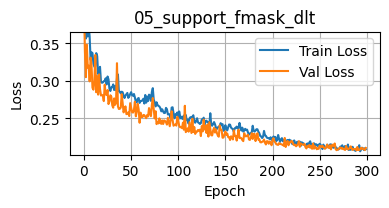

Minimum Validation Loss:  0.2074533448769496
DONE WITH  05_support_fmask_dlt
=== NEW EXPERIMENT ===
 --> Name: 06_support_fmask_dlt_dem
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 300/300 [08:56<00:00,  1.79s/it]


Results saved to: ../results/train/06_support_fmask_dlt_dem


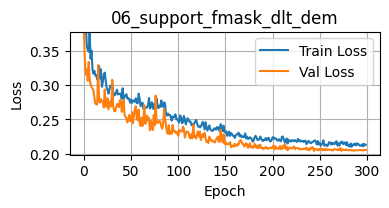

Minimum Validation Loss:  0.20391987378780657
DONE WITH  06_support_fmask_dlt_dem
=== NEW EXPERIMENT ===
 --> Name: 07_aux_task
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 300/300 [11:03<00:00,  2.21s/it]


Results saved to: ../results/train/07_aux_task


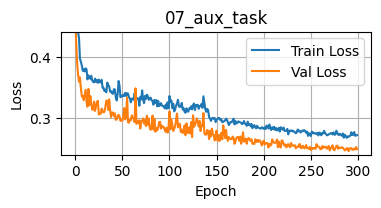

Minimum Validation Loss:  0.24563013486440669
DONE WITH  07_aux_task


In [93]:
for exp_name in experiment_names:
    
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")


## 250 again

In [118]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[:7]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
print(experiment_names)

['01_baseline', '02_pixel_composites', '03_seasonal_composites', '04_pixel_and_seasonal_comp', '05_support_fmask_dlt', '06_support_fmask_dlt_dem', '07_aux_task']


=== NEW EXPERIMENT ===
 --> Name: 01_baseline
Train dataset valid pixel share: 	0.9901, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9918, count: 176


Epochs: 100%|██████████| 250/250 [03:27<00:00,  1.21it/s]

Results saved to: ../results/train/01_baseline


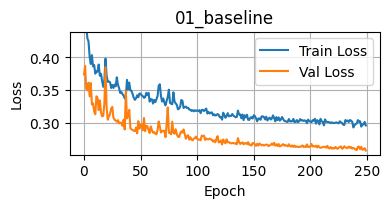

Minimum Validation Loss:  0.25763451104814356
DONE WITH  01_baseline
=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites
Train dataset valid pixel share: 	0.9896, count: 820
Validation dataset valid pixel share: 	0.9913, count: 176
Test dataset valid pixel share: 	0.9917, count: 176


Epochs:  32%|███▏      | 80/250 [01:41<03:36,  1.27s/it]

Early stopping triggered at epoch 81
Results saved to: ../results/train/02_pixel_composites


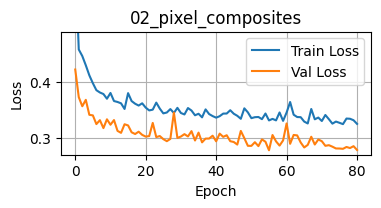

Minimum Validation Loss:  0.27776197411797265
DONE WITH  02_pixel_composites
=== NEW EXPERIMENT ===
 --> Name: 03_seasonal_composites
Train dataset valid pixel share: 	0.9794, count: 728
Validation dataset valid pixel share: 	0.9809, count: 156
Test dataset valid pixel share: 	0.9716, count: 157


Epochs: 100%|██████████| 250/250 [04:52<00:00,  1.17s/it]


Results saved to: ../results/train/03_seasonal_composites


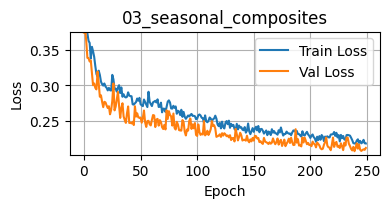

Minimum Validation Loss:  0.2065505706346952
DONE WITH  03_seasonal_composites
=== NEW EXPERIMENT ===
 --> Name: 04_pixel_and_seasonal_comp
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [05:50<00:00,  1.40s/it]


Results saved to: ../results/train/04_pixel_and_seasonal_comp


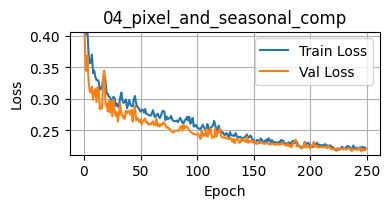

Minimum Validation Loss:  0.21640999271319464
DONE WITH  04_pixel_and_seasonal_comp
=== NEW EXPERIMENT ===
 --> Name: 05_support_fmask_dlt
Train dataset valid pixel share: 	0.9741, count: 728
Validation dataset valid pixel share: 	0.9779, count: 156
Test dataset valid pixel share: 	0.9671, count: 156


Epochs: 100%|██████████| 250/250 [04:54<00:00,  1.18s/it]


Results saved to: ../results/train/05_support_fmask_dlt


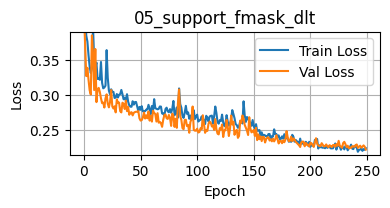

Minimum Validation Loss:  0.22136639860960153
DONE WITH  05_support_fmask_dlt
=== NEW EXPERIMENT ===
 --> Name: 06_support_fmask_dlt_dem
Train dataset valid pixel share: 	0.9740, count: 728
Validation dataset valid pixel share: 	0.9756, count: 156
Test dataset valid pixel share: 	0.9684, count: 157


Epochs: 100%|██████████| 250/250 [1:25:45<00:00, 20.58s/it]   


Results saved to: ../results/train/06_support_fmask_dlt_dem


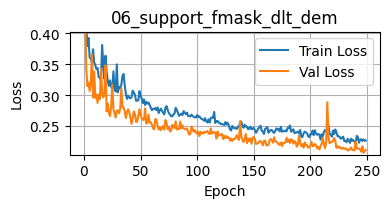

Minimum Validation Loss:  0.2069067393357937
DONE WITH  06_support_fmask_dlt_dem
=== NEW EXPERIMENT ===
 --> Name: 07_aux_task
Train dataset valid pixel share: 	0.9477, count: 846
Validation dataset valid pixel share: 	0.9596, count: 181
Test dataset valid pixel share: 	0.9511, count: 182


Epochs: 100%|██████████| 250/250 [06:09<00:00,  1.48s/it]


Results saved to: ../results/train/07_aux_task


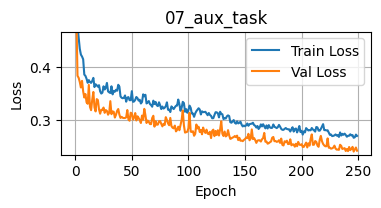

Minimum Validation Loss:  0.24098397379751363
DONE WITH  07_aux_task


In [ ]:
for exp_name in experiment_names:
    
    sites, cfg = cf.get_config(exp_name)  
    global_config = md.global_config
    cfg.update(global_config)  # Ensure cfg has the latest global_config
    print("=== NEW EXPERIMENT ===")
    print(f" --> Name: {exp_name}")
    # Build dataset
    X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
    # split into train/val/test (70/15/15) with your logic
    (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y)

    # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
    train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
    val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
    test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

    train_loader = md.DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
    val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
    test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
    print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
    print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
    print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")

    
    # build model depending on in out channels, defined by the dataloaders
    model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
    #train model depending on config. 
    model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

    md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=None)

    eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
    print("Minimum Validation Loss: ", min(logs['val_loss']))
    print("DONE WITH ", exp_name)
    print("==========")


## main run of experiments

In [80]:
# SELECT EXPERIMENTAL CONFIG
with open('../configs/experiments.yaml', 'r') as f:
    experiments = yaml.safe_load(f)
    experiment_names = list(experiments.keys())
    experiment_names = experiment_names[1:2]  # Select the first 6 experiment names

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']
print(experiment_names)

['02_pixel_composites']


In [81]:
normparams

{'chm': {'_001': {'mu': 29.136810302734375,
   'n': 424127,
   'std': 5.059319972991943},
  '_010': {'mu': 27.330501556396484, 'n': 331027, 'std': 6.319406986236572},
  '_011': {'mu': 28.345002320026218, 'n': 755154, 'std': 5.611687865810269},
  '_100': {'mu': 29.79595947265625, 'n': 753596, 'std': 9.429980278015137},
  '_101': {'mu': 29.5585836550901, 'n': 1177723, 'std': 7.85599807406007},
  '_110': {'mu': 29.043501579318452, 'n': 1084623, 'std': 8.480633136144107},
  '_111': {'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}},
 'info': {'description': 'CHM normalization parameters',
  'encoding': '001: FirstSite only, 010: Second Site, 100: Third Site',
  'version': '1.0'}}

In [ ]:
import random

global_config = md.global_config
# reproducible shuffling (num_workers=0 -> simpler)
seed = global_config['seed']
run_id_base = "251017_test"
repetitions = 1


for i in range(repetitions): # Run 10 experiments with different seeds
    #run_id = md.generate_run_id()
    run_id = run_id_base + f"_{i}"
    seed = seed + i  # Different seed for each experiment
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)

    for exp_name in experiment_names:
        
        sites, cfg = cf.get_config(exp_name)  
        cfg.update(global_config)  # Ensure cfg has the latest global_config
        print("=== NEW EXPERIMENT ===")
        print(f" --> Name: {exp_name}")

        # Build dataset
        X, Y = dt.build_patched_dataset(cfg, sites, patch_size=32)
        # split into train/val/test (70/15/15) with your logic
        (X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = dt.split_dataset(X, Y, seed=seed)

        # Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
        train_dataset = md.S2CanopyHeightDataset(X_train, Y_train, cfg)
        val_dataset = md.S2CanopyHeightDataset(X_val, Y_val, cfg)
        test_dataset = md.S2CanopyHeightDataset(X_test, Y_test, cfg)

        train_loader = md.DataLoader(
            train_dataset,
            batch_size=global_config['batch_size'],
            shuffle=True,
            num_workers=0
        )
        val_loader = md.DataLoader(val_dataset, batch_size=global_config['batch_size'])
        test_loader = md.DataLoader(test_dataset, batch_size=global_config['batch_size'])
        if False:
            print(f"Train dataset valid pixel share: \t{train_dataset.validshare():.4f}, count: {len(train_dataset)}")
            print(f"Validation dataset valid pixel share: \t{val_dataset.validshare():.4f}, count: {len(val_dataset)}")
            print(f"Test dataset valid pixel share: \t{test_dataset.validshare():.4f}, count: {len(test_dataset)}")
        
        # build model depending on in out channels, defined by the dataloaders
        model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
        #train model depending on config. 
        model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

        md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg, run_id=run_id)

        #eval.plot_val_loss(logs['train_loss'],logs['val_loss'], title=exp_name)
        #print("Minimum Validation Loss: ", min(logs['val_loss']))
        #print("DONE WITH ", exp_name)
        print("=================")
    print("DONE WITH ALL EXPERIMENTS for iteration ", i)

=== NEW EXPERIMENT ===
 --> Name: 02_pixel_composites


Epochs:   0%|          | 2/500 [00:02<09:13,  1.11s/it]


KeyboardInterrupt: 

In [110]:
cfg

{'spectral': {'seasons': ['summer'], 'quantiles': ['Q25', 'Q50', 'Q75']},
 'aux_inputs': ['FMASK'],
 'strategy': 'all_in_model',
 'outputs': {'canopy_height': {'target': 'CHM_norm', 'loss': 'huber'}},
 'exp': '02_pixel_composites',
 'seed': 47,
 'patch_size': 32,
 'num_bands': 15,
 'batch_size': 128,
 'learning_rate': 0.0008,
 'weight_decay': 0.0002,
 'scheduler_type': 'ReduceLROnPlateau',
 'scheduler_patience': 15,
 'scheduler_factor': 0.5,
 'scheduler_min_lr': 1e-06,
 'early_stopping_patience': 75,
 'epochs': 500,
 'huber_delta': 1.35,
 'device': 'mps'}

In [59]:
RGB_indices = [10, 3, 0]  # basic setup
len(RGB_indices)

3

In [109]:
# build dataframe with all channel-season-quantile combinations
seasons = ['spring', 'summer', 'autumn']
#seasons = ['summer']
quantiles = ['q1', 'q2', 'q3']
quantiles = ['q2']
channels = ['BLU','BNR','EVI','GRN','NBR','NDV','NIR','RE1','RE2','RE3','RED','SW1','SW2']

names = [f"{ch}_{season}_{q}" for season in seasons for ch in channels for q in quantiles]
df_test = pd.DataFrame({'Name': names})
df_test['season'] = df_test['Name'].apply(lambda x: x.split('_')[1])
df_test['quantile'] = df_test['Name'].apply(lambda x: x.split('_')[2])
df_test['channel'] = df_test['Name'].apply(lambda x: x.split('_')[0])
#df_test['idx'] = df_test.index  # index as a column (at the end)
# get indices for RED, GRN, BLU in summer q2 (robust to missing entries)
targets = ['RED', 'GRN', 'BLU']
indices = []
for ch in targets:
    idxs = df_test.loc[
        (df_test['season'] == 'summer') &
        (df_test['quantile'] == 'q2') &
        (df_test['channel'] == ch)
    ].index.tolist()
    indices.append(idxs[0] if idxs else None)

print("Indices for RED, GRN, BLU (season=summer, quantile=q2):", indices)

Indices for RED, GRN, BLU (season=summer, quantile=q2): [23, 16, 13]


In [ ]:
def get_rgb_indices(cfg):
    "return indices for RED, GRN, BLU in summer Q50"
    seasons = cfg['spectral'].get('seasons', [])
    quantiles = cfg['spectral'].get('quantiles', [])
    channels = ['BLU','BNR','EVI','GRN','NBR','NDV','NIR','RE1','RE2','RE3','RED','SW1','SW2']

    names = [f"{ch}_{season}_{q}" for season in seasons for ch in channels for q in quantiles]
    df = pd.DataFrame({'Name': names})
    df['season'] = df['Name'].apply(lambda x: x.split('_')[1])
    df['quantile'] = df['Name'].apply(lambda x: x.split('_')[2])
    df['channel'] = df['Name'].apply(lambda x: x.split('_')[0])

    targets = ['RED', 'GRN', 'BLU']
    indices = []
    for ch in targets:
        idxs = df.loc[
            (df['season'] == 'summer') &
            (df['quantile'] == 'Q50') &
            (df['channel'] == ch)
        ].index.tolist()
        indices.append(idxs[0] if idxs else None)

    return indices
#{'spectral': {'seasons': ['summer'], 'quantiles': ['Q25', 'Q50', 'Q75']},}

{'spectral': {'seasons': ['summer'], 'quantiles': ['Q25', 'Q50', 'Q75']}}

In [113]:
get_rgb_indices(cfg)

[31, 10, 1]

In [ ]:
x.shape[1]
# RGB_indices = [x + 13*4 for x in [10, 3, 0]] 
# print(RGB_indices)
QUANTILE_IDX = {"Q25": 0, "Q50": 1, "Q75": 2, "AVG": 3, "STD": 4}

stack = []
# Spectral inputs
seasons = cfg["spectral"]["seasons"] # (e.g., ['spring', 'summer', 'autumn'])
quantiles = cfg["spectral"]["quantiles"] # (e.g., ['Q25', 'Q50', 'Q75'])
for season in seasons:
    arr, desc = dt.read_multiband_tif_as_stack(site_paths["S2_norm"][season])  # returns (13, channels, H, W)
    arr = arr[:, [QUANTILE_IDX[q] for q in quantiles], :, :]           # select quantiles
    # flatten band x quantile dims into a single channel axis
    arr = arr.reshape(-1, arr.shape[-2], arr.shape[-1])  # -> (13 * len(quantiles), H, W)
    stack.append(arr)

RGB_indices = [10, 3, 0]
RGB_indices = [x + 13*4 for x in RGB_indices]

# compute Q50-based RGB channel indices in the stacked tensor

bands_per_season = 13
lenq = len(quantiles)
channels_per_season = bands_per_season * lenq

if 'Q50' in quantiles:
    q_pos = quantiles.index('Q50')
elif lenq == 1:
    q_pos = 0
else:
    q_pos = lenq // 2  # fallback to middle quantile

# prefer 'summer' season if available, otherwise use first season
season_idx = seasons.index('summer') if 'summer' in seasons else 0

base_rgb_bands = [10, 3, 0]
RGB_indices = [season_idx * channels_per_season + b * lenq + q_pos for b in base_rgb_bands]
RGB_indices
[10, 3, 0]
SP_Q25, SP_Q50, SP_Q75 = 0, 1, 2  # Example quantile indices
SUM_Q25, SUM_Q50, SUM_Q75 = 3, 4, 5



32

torch.Size([176, 40, 32, 32])
Using RGB indices:  [31, 10, 1]
Transposing channels
(3, 32, 32)
(32, 32, 3)
Red min/max:  0.012903226 0.25278592
Green min/max:  0.0 0.34603176
Blue min/max:  0.016664738 0.22127068


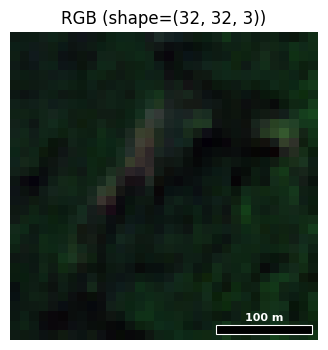

In [108]:
# plot rgb (handles both HxWxC and CxHxW layouts and optional batch dim)
rgb = test_dataset.getRGB(3)

img = rgb.copy()

# if there's a batch dimension, take the first sample
if img.ndim == 4:
    img = img[0]

# channels-first (C,H,W) -> channels-last (H,W,C)
if img.ndim == 3 and img.shape[0] in (1, 3):
    print("Transposing channels")
    print(img.shape)
    img = np.transpose(img, (1, 2, 0))
    print(img.shape)

img = img.astype(np.float32)
#img = np.clip(img, 0.0, 1.0)

print("Red min/max: ", img[:,:,0].min(), img[:,:,0].max())
print("Green min/max: ", img[:,:,1].min(), img[:,:,1].max())
print("Blue min/max: ", img[:,:,2].min(), img[:,:,2].max())

plt.figure(figsize=(4, 4))
brightness_factor = 1.0  # Adjust this factor to increase/decrease brightness
img = np.clip(img * brightness_factor, 0.0, 1.0)
plt.imshow(img.squeeze())
# add a scale bar (1 pixel == 10 m) in the bottom-right corner using axes-fraction coords
ax = plt.gca()
w = img.shape[1]
# fraction width corresponding to 10 pixels (10 px == 100 m)
bar_frac_w = 10.0 / w
bar_frac_h = 0.03  # bar height as fraction of axes
pad = 0.02  # padding from edges as fraction

bar_x = 1.0 - pad - bar_frac_w
bar_y = pad

rect = plt.Rectangle((bar_x, bar_y), bar_frac_w, bar_frac_h,
                     transform=ax.transAxes, facecolor='black',
                     edgecolor='white', linewidth=0.8, zorder=10)
ax.add_patch(rect)
ax.text(bar_x + bar_frac_w / 2, bar_y + bar_frac_h + 0.005,
        '100 m', transform=ax.transAxes,
        ha='center', va='bottom', color='white', fontsize=8, weight='bold', zorder=11)

plt.title(f"RGB (shape={img.shape})")
plt.axis('off')
plt.show()

# individual tests, to be cleared

## 1st experiment: BASELINE

In [183]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("baseline")  
global_config = md.global_config

with open('../configs/normparams.yaml', 'r') as f:
    normparams = yaml.safe_load(f)
joint_normparams = normparams['chm']['_111']

In [ ]:
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

In [146]:
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [01:46<00:00,  1.41it/s]


In [148]:
md.save_results(model, logs, cfg)

Results saved to: ../results/train/baseline


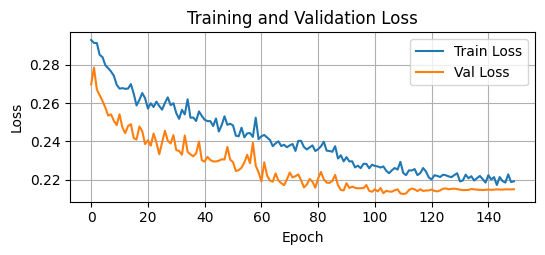

In [147]:
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])

## 2nd Experiment: + PIXEL COMPOSITES Q25, Q50, Q75

In [149]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = S2CanopyHeightDataset(X_val, Y_val)
test_dataset = S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:34<00:00,  1.03s/it]


Results saved to: ../results/train/pixel_composites


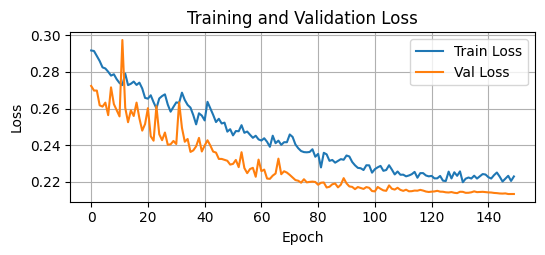

In [150]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])


In [151]:
print("Minimum Validation Loss: ", min(logs['val_loss']))

Minimum Validation Loss:  0.2132713171568784


In [152]:
X.shape

(1172, 40, 32, 32)

## 3rd experiment: seasonal_composites

In [153]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("seasonal_composites")  
global_config = md.global_config

# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:33<00:00,  1.02s/it]


Results saved to: ../results/train/seasonal_composites


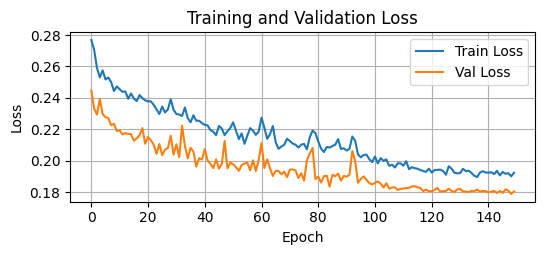

Minimum Validation Loss:  0.17872493618573898


In [ ]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 4th experiment: pixel_and_seasonal

In [155]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("pixel_and_seasonal")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:43<00:00,  1.09s/it]


Results saved to: ../results/train/pixel_and_seasonal


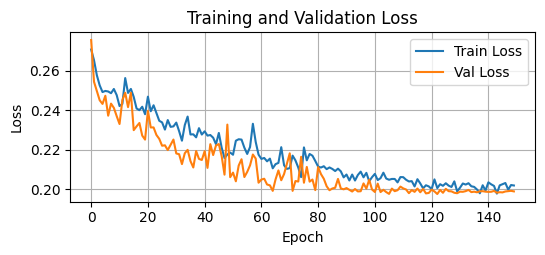

Minimum Validation Loss:  0.19751727198943114


In [156]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 5th experiment: pixel_and_seasonal + all aux

In [157]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("all_aux_data")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Loading dataset...
Building data-loaders...
Training ...


Epochs: 100%|██████████| 150/150 [02:40<00:00,  1.07s/it]


Results saved to: ../results/train/all_aux_data


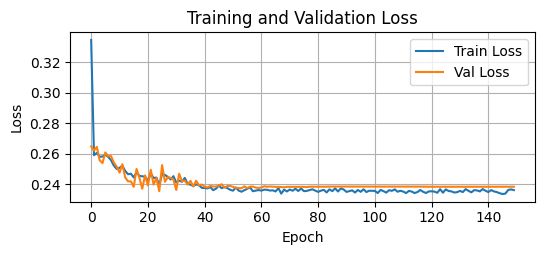

Minimum Validation Loss:  0.23547424108554155


In [158]:
md.save_results(model, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

## 6th experiment: Mid-Level-Learning

In [ ]:
# SELECT EXPERIMENTAL CONFIG
sites, cfg = get_config("mid_level_learning")  
global_config = md.global_config

print("Loading dataset...")
# Build dataset
X, Y = build_patched_dataset(cfg, sites, patch_size=32)
# split into train/val/test (70/15/15) with your logic
(X_train, Y_train), (X_val, Y_val), (X_test, Y_test) = split_dataset(X, Y)

print("Building data-loaders...")
# Syntax: X_train, X_val, X_test, y_train, y_val, y_test 
train_dataset = md.S2CanopyHeightDataset(X_train, Y_train)
val_dataset = md.S2CanopyHeightDataset(X_val, Y_val)
test_dataset = md.S2CanopyHeightDataset(X_test, Y_test)

train_loader = DataLoader(train_dataset, batch_size=global_config['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=global_config['batch_size'])
test_loader = DataLoader(test_dataset, batch_size=global_config['batch_size'])

print("Training ...")
# build model depending on in out channels, defined by the dataloaders
model = md.build_unet(in_channels=X[0].shape[0], out_channels=Y[0].shape[0])
#train model depending on config. 
model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

In [ ]:
#model, logs = md.train_model(model, train_loader, val_loader, cfg, md.global_config)

Epochs: 100%|██████████| 150/150 [02:16<00:00,  1.10it/s]


In [186]:
test_loader

Results saved to: ../results/train/baseline


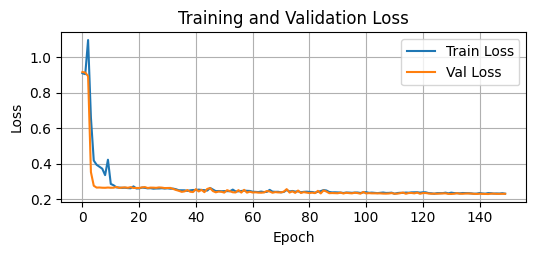

Minimum Validation Loss:  0.22883993050744456


In [197]:
md.save_results(model, val_loader, test_loader, joint_normparams, logs, cfg)
eval.plot_val_loss(logs['train_loss'],logs['val_loss'])
print("Minimum Validation Loss: ", min(logs['val_loss']))

{'chm': {'_001': {'mu': 29.136810302734375, 'n': 424127, 'std': 5.059319972991943}, '_010': {'mu': 27.330501556396484, 'n': 331027, 'std': 6.319406986236572}, '_011': {'mu': 28.345002320026218, 'n': 755154, 'std': 5.611687865810269}, '_100': {'mu': 29.79595947265625, 'n': 753596, 'std': 9.429980278015137}, '_101': {'mu': 29.5585836550901, 'n': 1177723, 'std': 7.85599807406007}, '_110': {'mu': 29.043501579318452, 'n': 1084623, 'std': 8.480633136144107}, '_111': {'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}}, 'info': {'description': 'CHM normalization parameters', 'encoding': '001: FirstSite only, 010: Second Site, 100: Third Site', 'version': '1.0'}}


{'mu': 29.069731736028462, 'n': 1508750, 'std': 7.518862605606749}

In [181]:
test_np_array = np.random.rand(1, 15, 32, 32)
denormalized_array = md.denormalize_chm(test_np_array, normparams['chm']['_111'])

In [199]:
cfg['exp']

'baseline'

In [200]:
direc

'../results/train/baseline'

In [201]:
direc = os.path.join("../results/train", cfg['exp'])
preds_val, targets_val, preds_test, targets_test = md.load_np_stacks(cfg['exp'])

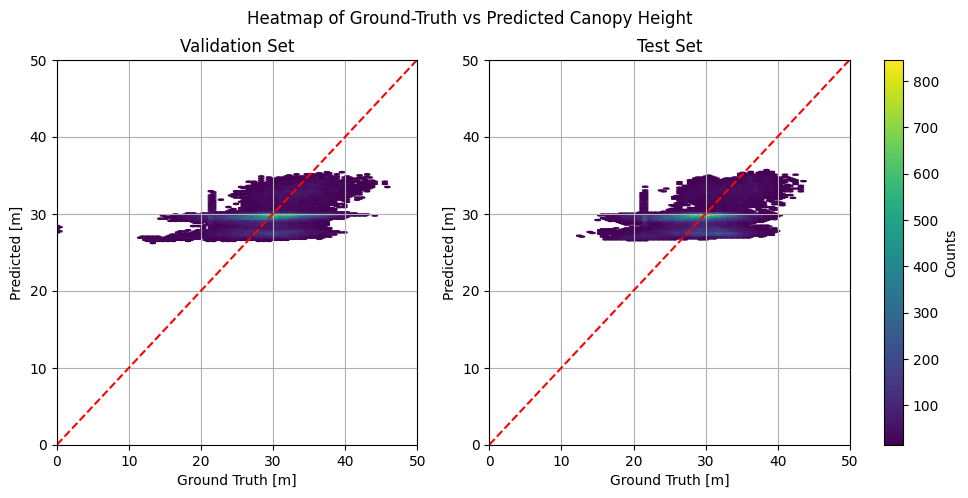

In [207]:
eval.plot_compact_heatmap_val_test(targets_val[:,0,:,:], preds_val[:,0,:,:], targets_test[:,0,:,:], preds_test[:,0,:,:], title="Heatmap of Ground-Truth vs Predicted Canopy Height\n")


In [206]:
preds_val[:,0,:,:]

array([[[29.228334, 29.195019, 29.318298, ..., 27.625126, 27.849678,
         28.368935],
        [29.231817, 29.20908 , 29.382376, ..., 26.858475, 27.1299  ,
         27.87675 ],
        [29.268469, 29.16478 , 29.35746 , ..., 26.605225, 26.798773,
         26.837229],
        ...,
        [28.213467, 27.70534 , 27.69547 , ..., 27.492243, 27.587065,
         27.685926],
        [28.322487, 27.850323, 27.838842, ..., 27.577091, 27.704319,
         27.079586],
        [28.692356, 28.366812, 27.742432, ..., 27.100689, 26.99114 ,
         26.250057]],

       [[30.783464, 30.952011, 30.785635, ..., 32.734894, 32.696148,
         32.065117],
        [31.00191 , 31.770645, 31.824152, ..., 32.94192 , 32.87419 ,
         31.767637],
        [31.321087, 32.02757 , 32.021038, ..., 32.955334, 33.128983,
         32.101448],
        ...,
        [32.383842, 33.035633, 33.60624 , ..., 30.142529, 30.254604,
         29.958284],
        [31.940338, 32.879642, 33.48127 , ..., 30.311537, 30.388004,
   